In [14]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [15]:
%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [16]:
meta = pd.read_csv('Articoli Taggati v8.csv', sep=";", skipinitialspace = True, quotechar='"')
meta = meta.replace(np.nan, '', regex=True)
del(meta['Unnamed: 0'])
del(meta['Keywords'])
del(meta['Txt'])
#del(meta['Tags'])

In [17]:
meta.head()

,ID,Titolo,Data,Trend,Anno,Mese,Day,Week,Tags,Tech,Company,Vertical,Application,Location,Tag
0,c812e0a3418d624ae60df3ec9e19d184,pandemic drone spot infected,03/04/2020,Robotics and Human/Machine Hybridization,2020,4,3,14,Tech: Drones,Drones,,,,,
1,0e2ef6bd7619374e0531d1551ab2141e,census data anonymous expected,07/04/2020,Privacy and Security by design,2020,4,7,15,"Company: Adobe, Vertical: Advertising",,Adobe,Advertising,,,
2,8602d8791a1754506303dcfd9a7b79e3,common pandemic scams highlighted domain name analysis,11/05/2020,Cyber Defense and Fight against Fakes,2020,5,11,20,,,,,,,
3,2157ac6d12e063b6a38c5c0491e0b322,questions rapidly unfolding future smart fabrics,11/05/2020,Workforce Transformation,2020,5,11,20,Tag: Future,,,,,,Future
4,3c06ef110a3efad83733ad876816e16f,things ceo expect remote work life,17/05/2020,Workforce Transformation,2020,5,17,20,,,,,,,


In [18]:
meta.columns

Index(['ID', 'Titolo', 'Data', 'Trend', 'Anno', 'Mese', 'Day', 'Week', 'Tags',
       'Tech', 'Company', 'Vertical', 'Application', 'Location', 'Tag'],
      dtype='object')

In [19]:
trend_week = meta.groupby(["Trend", "Anno", "Week"]).size().reset_index(name="Count")
trend_week['Data']=trend_week.apply(lambda x:'%sw%s' % (x['Anno'],x['Week']),axis=1)

In [20]:
trend_week.head()

,Trend,Anno,Week,Count,Data
0,3D Printing and New Materials,2020,13,1,2020w13
1,3D Printing and New Materials,2020,14,1,2020w14
2,3D Printing and New Materials,2020,15,2,2020w15
3,3D Printing and New Materials,2020,19,2,2020w19
4,3D Printing and New Materials,2020,20,1,2020w20


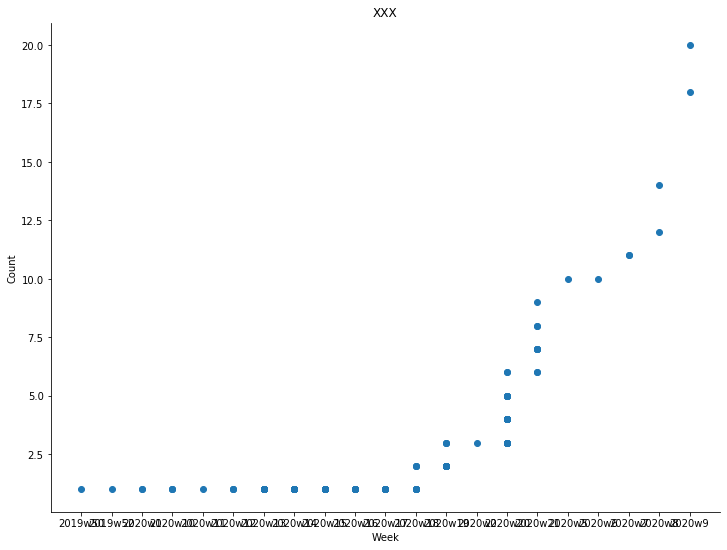

In [21]:
plt.figure(figsize=(12, 9))
plt.scatter(np.sort(trend_week['Data'].values), np.sort(trend_week['Count'].values))
plt.xlabel('Week')
plt.ylabel('Count')
plt.title("XXX")
sns.despine()

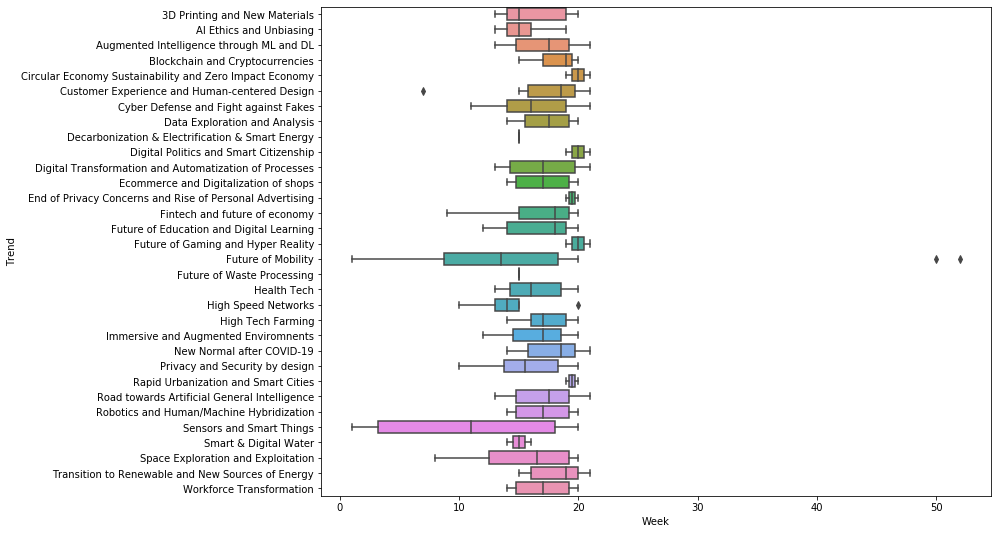

In [22]:
# Generate a Boxplot
plt.figure(figsize=(12, 9))
sns.boxplot( x=trend_week["Week"], y=trend_week["Trend"] )

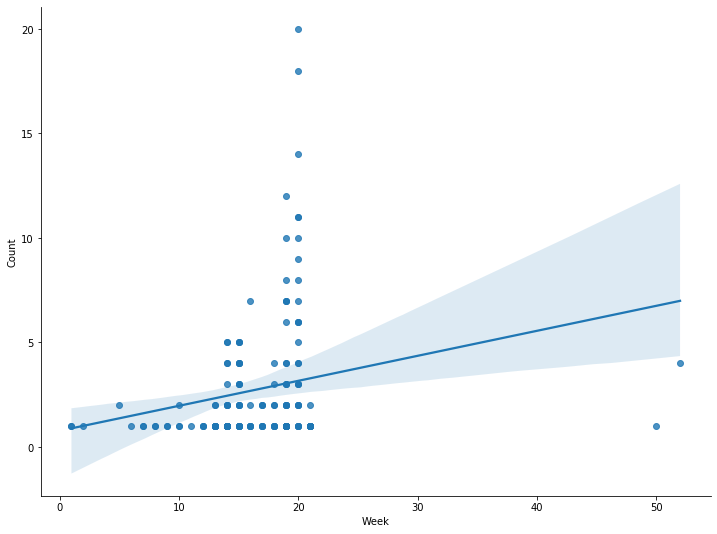

In [23]:
plt.figure(figsize=(12, 9))
sns.regplot(x="Week", y="Count", data=trend_week)
sns.despine();

In [24]:
articoli = meta[['ID','Trend', 'Tags', 'Anno', 'Mese', 'Week']]
articoli.head()

,ID,Trend,Tags,Anno,Mese,Week
0,c812e0a3418d624ae60df3ec9e19d184,Robotics and Human/Machine Hybridization,Tech: Drones,2020,4,14
1,0e2ef6bd7619374e0531d1551ab2141e,Privacy and Security by design,"Company: Adobe, Vertical: Advertising",2020,4,15
2,8602d8791a1754506303dcfd9a7b79e3,Cyber Defense and Fight against Fakes,,2020,5,20
3,2157ac6d12e063b6a38c5c0491e0b322,Workforce Transformation,Tag: Future,2020,5,20
4,3c06ef110a3efad83733ad876816e16f,Workforce Transformation,,2020,5,20


In [25]:
ds = articoli.set_index(['Trend', 'Week']).Tags.str.split(',',expand=True).stack().reset_index().loc[:, ['Trend','Week', 0]].rename({0: 'Tag'}, axis='columns')
ds.head()

,Trend,Week,Tag
0,Robotics and Human/Machine Hybridization,14,Tech: Drones
1,Privacy and Security by design,15,Company: Adobe
2,Privacy and Security by design,15,Vertical: Advertising
3,Cyber Defense and Fight against Fakes,20,
4,Workforce Transformation,20,Tag: Future


In [26]:
tags_for_trend = ds.groupby(["Trend", "Tag"]).size().reset_index(name="Count").groupby(['Trend'])['Tag'].apply(', '.join).reset_index()

In [27]:
def deduplica(text):
    str_list = text.split(",")
    str_list = list(map(str.strip, str_list))
    str_list = list(filter(None, str_list))
    str_list = list(set(str_list))
   
    str_list = ", " . join(str_list)
    return str_list
    
deduplica(tags_for_trend['Tag'][3])

tags_for_trend['Tag'] = tags_for_trend['Tag'].apply(lambda x: deduplica(x))

In [28]:
tags_for_trend.head()

,Trend,Tag
0,3D Printing and New Materials,"Tech: Artificial Intelligence, Vertical: Food, Vertical: Energy"
1,AI Ethics and Unbiasing,"Company: Amazon, Vertical: Advertising, Vertical: Sports, Location: China, Application: Personal Assistant, Tech: Artificial Intelligence"
2,Augmented Intelligence through ML and DL,"Tech: Deep Learning, Vertical: Automotive, Vertical: M&A, Application: Driverless Vehicles, Tech: Mobile app, Application: E-Commerce, Application: Contact Center, Tech: Augmented Reality, Company: Facebook, Company: Apple, Company: Amazon, Location: Boston, Vertical: Fintech, Application: Deep ..."
3,Blockchain and Cryptocurrencies,"Application: Renewables, Vertical: Finance, Company: Amazon, Application: Cryptocurrencies, Vertical: Banking, Tech: Cloud, Company: Microsoft, Application: Digitalization, Tech: Blockchain, Vertical: Energy"
4,Circular Economy Sustainability and Zero Impact Economy,"Application: Renewables, Vertical: Biology, Vertical: Fashion, Vertical: Aviation, Vertical: Energy, Vertical: Food, Location: Africa, Application: Advanced Analytics"


In [29]:
df = ds.groupby(["Week", "Trend"]).size().reset_index(name="Count")
#df["Data"] = df["Anno"].astype(int).astype(str) + df["Mese"].astype(str)
#del(df['Anno'])
#del(df['Mese'])
df.head()

,Week,Trend,Count
0,1,Future of Mobility,1
1,1,Sensors and Smart Things,2
2,2,Sensors and Smart Things,1
3,5,Future of Mobility,2
4,6,Future of Mobility,1


In [30]:
df.loc[df['Trend'] == "Sensors and Smart Things"]

,Week,Trend,Count
1,1,Sensors and Smart Things,2
2,2,Sensors and Smart Things,1
6,7,Sensors and Smart Things,1
66,15,Sensors and Smart Things,3
116,19,Sensors and Smart Things,1
143,20,Sensors and Smart Things,1


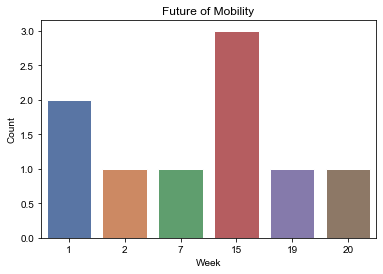

In [31]:
plt.title("Future of Mobility")

sns.set(rc={'figure.figsize':(13,8)})
sns.barplot(x="Week", y="Count", data=df.loc[df['Trend'] == "Sensors and Smart Things"])

In [32]:
articles_per_trend = meta.groupby("Trend").size().reset_index(name="Count")
articles_per_trend = articles_per_trend.sort_values("Count", ascending=False)
articles_per_trend.head()

,Trend,Count
22,New Normal after COVID-19,44
16,Future of Mobility,41
6,Cyber Defense and Fight against Fakes,28
13,Fintech and future of economy,27
2,Augmented Intelligence through ML and DL,25


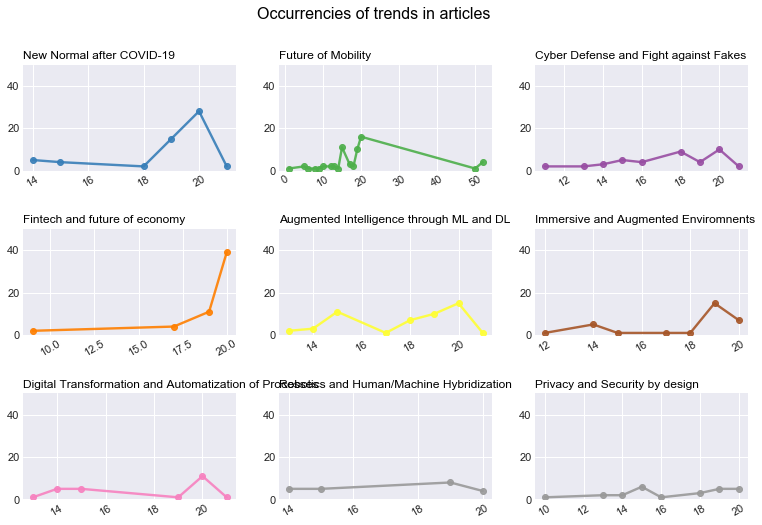

In [33]:
# https://python-graph-gallery.com/125-small-multiples-for-line-chart/

# Initialize the figure
plt.style.use('seaborn-darkgrid')

# create a color palette
palette = plt.get_cmap('Set1')

n = 0
trends = articles_per_trend["Trend"].unique()
for i in trends:
    n+=1

    d = df.loc[df['Trend'] == i]
    plt.subplot(3,3, n)
    plt.ylim(0,50)
    plt.plot(d['Week'], d['Count'], marker='o', color=palette(n), linewidth=2.4, \
             alpha=0.9, label=i)
    plt.xticks(rotation=30)
    plt.title(i, loc='left', fontsize=12, fontweight=0, color="black" )
    
    if n == 9:
        break

# general title
plt.suptitle("Occurrencies of trends in articles", fontsize=16, fontweight=0, color='black')
plt.subplots_adjust(hspace=0.55)

In [35]:
articles_per_vertical = meta.groupby("Vertical").size().reset_index(name="Count")
articles_per_vertical = articles_per_vertical.sort_values("Count", ascending=False)

In [36]:
df = meta.groupby(["Week", "Vertical"]).size().reset_index(name="Count")
#df["Data"] = df["Anno"].astype(int).astype(str) + df["Mese"].astype(str)
#del(df['Anno'])
#del(df['Mese'])
df.head()

,Week,Vertical,Count
0,1,,2
1,2,,1
2,5,,2
3,6,,1
4,7,,1


19


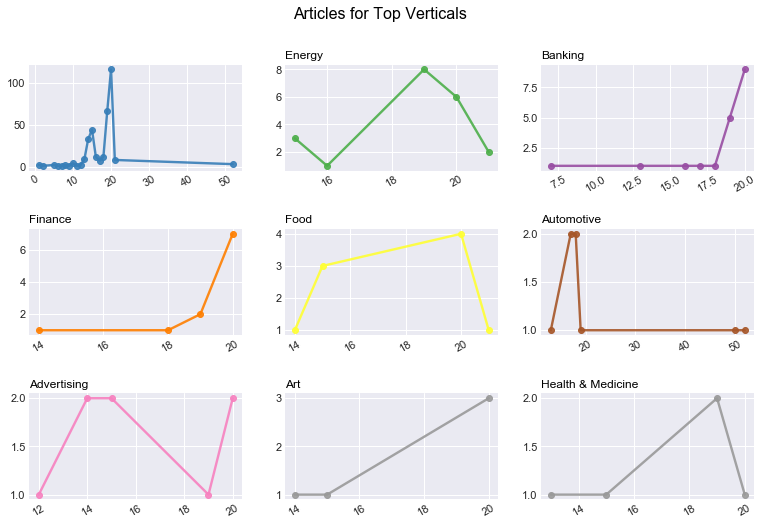

In [37]:
# https://python-graph-gallery.com/125-small-multiples-for-line-chart/

# Initialize the figure
plt.style.use('seaborn-darkgrid')

# create a color palette
palette = plt.get_cmap('Set1')

n = 0
vertical = articles_per_vertical["Vertical"].unique()
print (len(vertical))
for i in vertical:
    n+=1

    d = df.loc[df['Vertical'] == i]
    plt.subplot(3,3, n)
    #plt.ylim(0,120)
    plt.plot(d['Week'], d['Count'], marker='o', color=palette(n), linewidth=2.4, \
             alpha=0.9, label=i)
    plt.xticks(rotation=30)
    plt.title(i, loc='left', fontsize=12, fontweight=0, color="black" )
    
    if n == 9:
        break

# general title
plt.suptitle("Articles for Top Verticals", fontsize=16, fontweight=0, color='black')
plt.subplots_adjust(hspace=0.55)

In [38]:
tech_week = meta.groupby(["Tech", "Week"]).size().reset_index(name="Count")
#tech_week = tech_week.replace(np.nan, '', regex=True)

In [39]:
tech_week.head()

,Tech,Week,Count
0,,1,1
1,,2,1
2,,5,2
3,,6,1
4,,7,1
